In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import cupy as cp
import math
import time
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# defining the dataset path - important to match to the actual data file location
file_path = "/content/drive/My Drive/Colab Notebooks/gpu_project/MLoGPU_data3_train.csv"

dataFrame = pd.read_csv(file_path, header = None)

dataFrame.head()

,0,1,2,3,4,5,6,7
0,0.147035,1.264512,-0.474615,-0.543303,-1.091289,0.590143,-1.599582,4.0
1,0.559923,1.935253,-2.557251,-0.743111,-0.696480,-0.085936,-1.899705,6.0
2,0.766367,-0.496182,0.373866,0.170298,-0.544630,-0.592996,0.634732,4.0
3,-1.642146,0.426087,0.913809,1.397691,1.338306,-0.818356,0.367963,3.0
4,-0.334668,0.090717,1.608021,0.627002,2.644213,-0.367636,1.234998,4.0


<Axes: xlabel='7'>

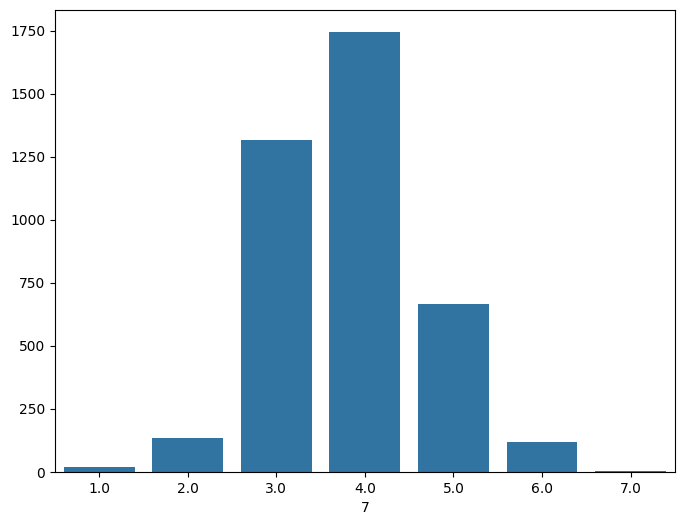

In [4]:
# plotting the class distribution
classcounts = dataFrame.iloc[:, -1].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=classcounts.index, y=classcounts.values)

In [5]:
def preprocess_data(df):
    """
    Preprocesses the dataset by normalizing features utilizing MinMaxScaler
    and then splitting into training and testing sets.

    input: df - pandas dataframe
    output: X_train, X_test, y_train, y_test - preprocessed dataframes and series
    """
    # normalize features using MinMaxScaler
    scaler = MinMaxScaler()
    df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

    # split features and label
    X = dataFrame.iloc[:, :-1]
    y = dataFrame.iloc[:, -1].astype(int)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

In [6]:
#custom kernel to conduct knn on gpu to produce predicted labels for the test data
compute_knn_predict = cp.RawKernel(r'''
extern "C" __global__ void compute_knn_predict(
    const float *X_train, const float *X_test, const int *y_train,
    int *predicted_labels, int train_data_size, int test_data_size, int num_features, int k)
{
    int test_index = blockIdx.x * blockDim.x + threadIdx.x; //getting the index of the current thread (for one test sample)

    if (test_index >= test_data_size) return; //if the thread is out of bound then exit

    //setting maximum limits for allocating memory
    #define MAX_FEATURES 7
    #define MAX_K 30
    #define MAX_CLASSES 7

    //if feature count or value of k exceeds the set limits, we exit to avoid crashes
    if (num_features > MAX_FEATURES || k > MAX_K) return;

    //allocating local memory for storing the current test sample
    float test_sample[MAX_FEATURES];

    //arrays for tracking top-k distances and their associated indices
    float top_k_distances[MAX_K];
    int top_k_indices[MAX_K];

    // as first step, we are loading test sample's features into local memory
    for (int f = 0; f < num_features; f++) {
        test_sample[f] = X_test[test_index * num_features + f];
    }

    // initializing top-k array with values as max float value so any lower distance can replace it
    for (int i = 0; i < k; i++) {
        top_k_distances[i] = 3.402823e+38;  // max float value
        top_k_indices[i] = -1;  //placing an invalid index to act as a placeholder since no neighbour found yet
    }

    // looping over all train samples for computing distances from test sample and compute top_k values
    for (int train_index = 0; train_index < train_data_size; train_index++) {

        float distance = 0.0; // for holding the sum of squared differences
        //computing euclidean distances between current test sample and training sample
        for (int f = 0; f < num_features; f++) {
            float diff = X_train[train_index * num_features + f] - test_sample[f];
            distance += (diff * diff);
        }

        // if the distance is small enough, we insert the distance and index in the top-k lists
        if (distance < top_k_distances[k - 1]) {
            int insert_position = k - 1; //starting from the last position in the top-k list

            //shifting higher distances to the right to keep list sorted to make the new insertion
            while (insert_position > 0 && distance < top_k_distances[insert_position - 1]) {
                top_k_distances[insert_position] = top_k_distances[insert_position - 1]; //moving larger distance to the right by 1 step
                top_k_indices[insert_position] = top_k_indices[insert_position - 1]; //moving the related index as well similarly
                insert_position--; //moving left for continuing to find where to insert
            }
            //inserting the new distance and its associated training sample index in the correct position in the lists
            top_k_distances[insert_position] = distance;
            top_k_indices[insert_position] = train_index;
        }
    }

    // counting all class labels from the top-k neighbours we found
    int class_votes[MAX_CLASSES] = {0}; //for counting frequency of each class
    for (int i = 0; i < k; i++) {
        int label = y_train[top_k_indices[i]]; //get the label of the i-th neighbour
        //making sure label is within range and then, incrementing label's count
        if (label >= 0 && label < MAX_CLASSES) {
            class_votes[label]++;
        }
    }

    // finally, finding the label with the highest count for final prediction

    // variables to keep track of the highest count and its label
    int max_votes = 0;
    int predicted_label = -1;

    //looping through for all classes to find the class with highest count
    for (int c = 0; c < MAX_CLASSES; c++) {
        if (class_votes[c] > max_votes) {
            max_votes = class_votes[c];
            predicted_label = c;
        }
    }

    predicted_labels[test_index] = predicted_label; //saving the predicted label for current test sample in the output array
}
''', 'compute_knn_predict')

In [7]:
def knn_gpu(X_train, X_test, y_train, y_test, k=7):
    '''
    conducts k-nearest neighbours algorithm on GPU utilizing a custom kernel
    input: - X_train (dataframe): training dataset
          - X_test (dataframe): testing dataset
          - y_train (series): training labels
          - y_test (series): testing dataset's true labels
          - k (int): no. of nearest neighbors being considered.

    output:
          - accuracy (float): this is the classification accuracy on the test set.
          - gpu_time (float): this is the total time taken for prediction using gpu (in seconds).
          - y_pred_gpu (cupy array): these are all the predicted labels from GPU.
    '''
    start_time = time.time()

    num_train_data, number_features = X_train.shape
    num_test_data = X_test.shape[0]

    # moving data to GPU
    X_train_gpu = cp.asarray(X_train, dtype=cp.float32)
    X_test_gpu = cp.asarray(X_test, dtype=cp.float32)
    y_train_gpu = cp.asarray(y_train.to_numpy(), dtype=cp.int32)
    y_test_gpu = cp.asarray(y_test.to_numpy(), dtype=cp.int32)

    # allocating output array for predictions
    y_pred_gpu = cp.zeros(num_test_data, dtype=cp.int32)

    # setting variables for kernel launch
    threads_per_block = 128
    blocks_per_grid = math.ceil(num_test_data / threads_per_block)

    # launching knn kernel
    compute_knn_predict(
        (blocks_per_grid,), (threads_per_block,),
        (
            X_train_gpu, X_test_gpu, y_train_gpu, y_pred_gpu,
            num_train_data, num_test_data, number_features, k
        )
    )

    # evaluating accuracy
    accuracy = cp.mean(y_pred_gpu == y_test_gpu).item()

    gpu_time = time.time() - start_time
    return accuracy, gpu_time, y_pred_gpu

## KNN in CPU
def knn_cpu(X_train, X_test, y_train, y_test, k=7):
    '''
    conducts the k-nearest neighbours algorithm on cpu

    input:
        - X_train (dataframe): Training features.
        - X_test (dataframe): Test features.
        - y_train (series): Training labels.
        - y_test (series): True test labels.
        - k (int): no. of nearest neighbors

    output:
          - accuracy (float): this is the classification accuracy on the test set.
          - gpu_time (float): this is the total time taken for prediction using cpu (in seconds).
          - y_pred_gpu (cupy array): these are all the predicted labels from cpu.
    '''
    start_time = time.time()

    # converting to numpy arrays
    X_train = X_train.to_numpy(dtype=np.float32)
    X_test = X_test.to_numpy(dtype=np.float32)
    y_train_ = y_train.to_numpy(dtype=int)
    y_test = y_test.to_numpy(dtype=int)

    num_test = X_test.shape[0]
    y_pred = np.zeros(num_test, dtype=int)

    i = 0
    for test_point in X_test:
        # computing squared euclidean
        distances = np.sum((X_train - test_point) ** 2, axis=1)

        # finding the indices of k smallest distances
        knn_indices = np.argsort(distances)[:k]

        # getting the corresponding class labels
        knn_labels = y_train[knn_indices]
        label_counts = np.bincount(knn_labels)

        # checking for ties in votes
        max_count = np.max(label_counts)
        max_label_indices = np.where(label_counts == max_count)[0]

        if len(max_label_indices) == 1:
            y_pred[i] = max_label_indices[0]
        else:
            # tie-breaking by recursively calling knn_cpu_single()
            new_k = k - 1 if k > 1 else 1
            y_pred[i] = knn_cpu_single(X_train, y_train, test_point, new_k)
        i += 1

    accuracy = np.mean(y_pred == y_test)
    cpu_time = time.time() - start_time

    return accuracy, cpu_time, y_pred

def knn_cpu_single(X_train, y_train, test_point, k):
    '''
    this is a helper function for knn_cpu to break ties using recursively reducing k.

    inputs:
        - X_train (ndarray): training dataset features.
        - y_train (ndarray): training dataset labels.
        - test_point (ndarray): this is a single test sample.
        - k (int): this current value of k.

    output:
        - label (int): this is the predicted label after resolving tie.
    '''
    #computing euclidean
    distances = np.sum((X_train - test_point) ** 2, axis=1)
    #finding k nearest neighbours
    knn_indices = np.argsort(distances)[:k]
    knn_labels = y_train[knn_indices]
    label_counts = np.bincount(knn_labels)
    max_count = np.max(label_counts)
    max_label_indices = np.where(label_counts == max_count)[0]

    if len(max_label_indices) == 1:
        return max_label_indices[0]
    elif k > 1:
        # reducing k value and trying again
        return knn_cpu_single(X_train, y_train, test_point, k - 1)
    else:
        # if there is still a tie and not possible to reduce k further, return smallest label
        return max_label_indices[0]

In [8]:
def evaluate_performance(y_true, y_pred_cpu, y_pred_gpu, cpu_times, gpu_times, cpu_accuracies, gpu_accuracies, k_values):
    """
    this function evaluates and does comparison on the performance of GPU vs CPU KNN.

    input:
        - y_true (array): this is the true class labels for test data
        - y_pred_cpu (array): this is the best predicted labels from CPU-based KNN
        - y_pred_gpu (array): this is the best predicted labels from GPU-based KNN
        - cpu_times (list): this is the computation times for CPU-based KNN over range of k values
        - gpu_times (list): this is the computation times for GPU-based KNN over range of k values
        - cpu_accuracies (list): this is the accuracy scores of CPU-based KNN over k
        - gpu_accuracies (list): this is the accuracy scores of GPU-based KNN over k
        - k_values (list): this is the values of k used during evaluation

    output:
        - none : this function displays plots and prints classification report
    """
    y_true = np.array(y_true)
    y_pred_cpu = np.array(y_pred_cpu)
    y_pred_gpu = np.array(y_pred_gpu)

    # confusion matrix
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_cpu), annot=True, fmt='d', cmap='Blues', ax=ax[0])
    ax[0].set_title("CPU Confusion Matrix")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    sns.heatmap(confusion_matrix(y_true, y_pred_gpu), annot=True, fmt='d', cmap='Purples', ax=ax[1])
    ax[1].set_title("GPU Confusion Matrix")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

    # GPU and CPU accuracies over k
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, cpu_accuracies, label="CPU Accuracy", marker='o')
    plt.plot(k_values, gpu_accuracies, label="GPU Accuracy", marker='o')
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs k")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plotting for the measured runtime of cpu & gpu over time
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, cpu_times, label="CPU Time (s)", marker='o')
    plt.plot(k_values, gpu_times, label="GPU Time (s)", marker='o')
    plt.xlabel("k")
    plt.ylabel("Time (seconds)")
    plt.title("Computation Time vs k")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plotting for the speedup factor (cpu/gpu) over k values
    speedups = [c/g if g > 0 else 0 for c, g in zip(cpu_times, gpu_times)]
    plt.figure(figsize=(10, 5))
    plt.plot(k_values, speedups, label="Speedup (CPU/GPU)", marker='o', color='purple')
    plt.xlabel("k")
    plt.ylabel("Speedup Factor")
    plt.title("GPU Speedup Over CPU vs k")
    plt.legend()
    plt.grid(True)
    plt.show()

    # classification reports
    cpu_report = classification_report(y_true, y_pred_cpu, output_dict=True)
    gpu_report = classification_report(y_true, y_pred_gpu, output_dict=True)

    cpu_df = pd.DataFrame(cpu_report).transpose()
    gpu_df = pd.DataFrame(gpu_report).transpose()

    comparison_df = pd.concat({'CPU': cpu_df, 'GPU': gpu_df}, axis=1)
    print("\n=== Classification Report Comparison (CPU vs GPU) ===\n")
    print(comparison_df.round(3))

In [ ]:
def main():
  # run preprocessing
  X_train, X_test, y_train, y_test = preprocess_data(dataFrame)

  # ---- comparing GPU vs. CPU Performance

  # warming up the gpu:
  for i in range(2):
    knn_gpu(X_train[:10], X_test[:2], y_train[:10], y_test[:2], k=1)

  # GPU -----
  best_gpu_acc = 0
  best_gpu_k = 0
  gpu_tot_time = 0
  gpu_tot_accuracy = 0
  gpu_times = []
  gpu_accs = []
  best_y_pred_gpu = None

  for k in range(1, 25):
      gpu_acc, gpu_time, gpu_pred = knn_gpu(X_train, X_test, y_train, y_test, k)
      gpu_tot_time += gpu_time
      gpu_tot_accuracy += gpu_acc
      gpu_times.append(gpu_time)
      gpu_accs.append(gpu_acc)
      if (gpu_acc > best_gpu_acc):
          best_gpu_k = k
          best_gpu_acc = gpu_acc
          best_y_pred_gpu = gpu_pred
      print("k: ", k)
      print(f"GPU kNN Accuracy: {gpu_acc:.4f}, Time: {gpu_time:.4f} seconds")
  average_gpu_time = gpu_tot_time / 24
  average_gpu_acc = gpu_tot_accuracy / 24
  best_y_pred_gpu =  cp.asnumpy(best_y_pred_gpu) #

  # CPU -----

  #fixing indices
  y_train = y_train.reset_index(drop=True)
  y_test = y_test.reset_index(drop=True)
  X_train = X_train.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)

  best_cpu_acc = 0
  best_cpu_k = 0
  cpu_tot_time = 0
  cpu_tot_accuracy = 0
  best_y_pred_cpu = None
  cpu_times = []
  cpu_accs = []

  for k in range(1, 25):
      cpu_acc, cpu_time, cpu_pred = knn_cpu(X_train, X_test, y_train, y_test, k)
      cpu_tot_time += cpu_time
      cpu_tot_accuracy += cpu_acc
      cpu_times.append(cpu_time)
      cpu_accs.append(cpu_acc)
      if (cpu_acc > best_cpu_acc):
          best_cpu_k = k
          best_cpu_acc = cpu_acc
          best_y_pred_cpu = cpu_pred
      print("k: ", k)
      print(f"CPU kNN Accuracy: {cpu_acc:.4f}, Time: {cpu_time:.4f} seconds")
  average_cpu_time = cpu_tot_time / 24
  average_cpu_acc = cpu_tot_accuracy / 24

  #--------------------
  # evaluating the performances of knn on cpu and gpu with visualizations, etc.
  evaluate_performance(
      y_test,
      best_y_pred_cpu,
      best_y_pred_gpu,
      cpu_times, gpu_times,
      cpu_accs, gpu_accs,
      list(range(1, 25))
  )

  #-------------------
  print("\nBest KNN Accuracy on GPU: ", best_gpu_acc, " with k = ", best_gpu_k)
  print("Best KNN Accuracy on CPU: ", best_cpu_acc, " with k = ", best_cpu_k)

  # comparing the averages
  print("\nTime Performance Comparison:")
  print(f"GPU kNN Average Accuracy: {average_gpu_acc:.4f}, Time: {average_gpu_time:.4f} seconds")
  print(f"CPU kNN Average Accuracy: {average_cpu_acc:.4f}, Time: {average_cpu_time:.4f} seconds")

  # computing speed up factor
  speedup = average_cpu_time / average_gpu_time
  print(f"\n GPU Average Speedup Over CPU: {speedup:.2f}x faster")

if __name__ == "__main__":
  main()